In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [106]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

In [606]:
refractory = 4e-3 # 4 ms
stop_time = 5000 # seconds
latency = 6e-3 # C response delay
# latency_std = 5e-4 # standard deviation of spike response in C
post_hit_rate = .8 # fraction of spikes that are driven by the presynaptic neuron
post_rate = 5 # Hz

pre_rate = 5

stim_latency = 5e-4 # .5 ms
# stim_latency_std = 5e-4
stim_rate = 30
hit_rate = .7 # fraction of spikes that are driven by the stimulation
stim_refractory = .05 # refractory time of stimulation
refractory_rate = .2 # fraction of spikes that happen just before stimulation



assert refractory_rate + hit_rate <= 1

winsize = 1e-3

In [607]:
def prune(random, refractory):
    spikes = []
    a = random.copy()
    while len(a) > 1:
        spikes.append(a[0])
        a = a[a - a[0] > refractory]
    return np.array(spikes)

In [608]:
stim_times = np.sort(np.random.uniform(0, stop_time, stim_rate * stop_time))
stim_times = prune(stim_times, stim_refractory)
n_stim = len(stim_times)

n_response = int(n_stim * hit_rate)
n_post = int(n_response * post_hit_rate)
n_refractory = int(n_stim * refractory_rate)

# response to stim_times
# stim_times_spikes = norm.rvs(loc=stim_times + stim_latency, scale=stim_latency_std)
# A_spikes = norm.rvs(loc=stim_times + stim_latency, scale=stim_latency_std)
# A_spikes = np.sort(stim_times_spikes[np.random.randint(0, n_stim, int(n_stim * hit_rate))])
# A_spikes = prune(A_spikes, refractory)
# B_spikes = norm.rvs(loc=stim_times + stim_latency, scale=stim_latency_std)
# B_spikes = np.sort(stim_times_spikes[np.random.randint(0, n_stim, int(n_stim * hit_rate))])
# B_spikes = prune(B_spikes, refractory)

# C_spikes = norm.rvs(loc=A_spikes + latency, scale=latency_std)
# C_spikes = prune(C_spikes, refractory)

In [611]:
def generate_neurons(n_post):
    idxs = np.random.permutation(np.arange(n_stim).astype(int))
    idxs_response = idxs[:n_response]

    spikes = np.sort(np.concatenate([
        stim_times[idxs_response] + stim_latency,
        np.sort(np.random.uniform(0, stop_time, pre_rate * stop_time))
    ]))
    spikes = prune(spikes, refractory)
    n_spikes = len(spikes)
    if n_post:
        post_idxs = np.random.permutation(np.arange(n_spikes).astype(int))[:n_post]

        response_spikes = np.sort(np.concatenate([
            spikes[post_idxs] + latency,
            np.random.uniform(0, stop_time, int(post_rate * stop_time))
        ]))
        response_spikes = prune(response_spikes, refractory)
    
        return spikes, response_spikes
    else:
        return spikes

In [610]:
A_spikes, C_spikes = generate_neurons(n_post)

B_spikes = generate_neurons(0)

In [612]:
def calculate_hit_rate(stim_times, target, winsize):
    src = np.searchsorted
    z0 = (# stim response
        src(target, stim_times, 'left') <
        src(target, stim_times + winsize, 'right'))
    z0 = z0 == 0
    z1 = z0 == False
    return sum(z1) / len(z1)

In [651]:
n_stim

60016

In [613]:
calculate_hit_rate(stim_times, A_spikes, .01)

0.7032791255665156

In [614]:
n_response / stop_time

8.4022

In [615]:
n_post / stop_time

6.7216

In [646]:
n_response / stop_time + pre_rate, n_post / stop_time + post_rate

(13.4022, 11.721599999999999)

In [616]:
# rate
len(A_spikes) / stop_time, len(B_spikes) / stop_time, len(C_spikes) / stop_time

(12.991, 12.963, 11.3486)

In [617]:
(len(C_spikes) / stop_time) / (n_post / stop_time) - 1

0.688377767198286

In [618]:
def vlines(X, label=None, **kwargs):
    '''
    Multiple vertical lines spanning the axes
    '''
    a = None
    for i, x in enumerate(X):
        if label and i == len(X)-1:
            kwargs.update({'label': label})
        a = plt.axvline(x, **kwargs)
    return a

(0.2, 0.45)

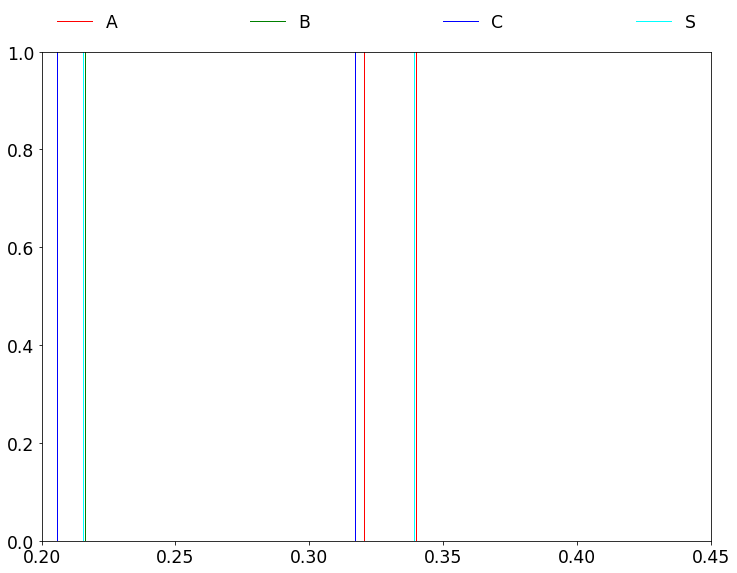

In [619]:
plt.figure()
t0, t1 = 0.2, 0.45
A_mask = (A_spikes > t0) & (A_spikes < t1)
B_mask = (B_spikes > t0) & (B_spikes < t1)
C_mask = (C_spikes > t0) & (C_spikes < t1)
S_mask = (stim_times > t0) & (stim_times < t1)
lw = 1
vlines(A_spikes[A_mask], label='A', color='r', lw=lw)
vlines(B_spikes[B_mask],label='B', color='g', lw=lw)
vlines(C_spikes[C_mask], label='C', color='b', lw=lw)
vlines(stim_times[S_mask], label='S', color='cyan', lw=lw)
plt.legend(bbox_to_anchor=(0., 1.01, 1., .102), loc=3,
           ncol=4, mode="expand", frameon=False)
plt.xlim(t0, t1)

In [620]:
assert all(np.diff(A_spikes) >= refractory)
assert all(np.diff(B_spikes) >= refractory)
assert all(np.diff(C_spikes) >= refractory)

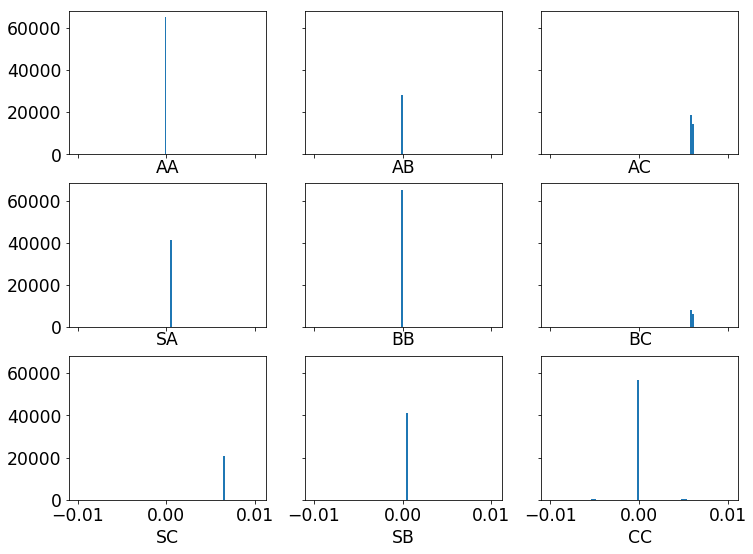

In [621]:
def xcorr(t1, t2, binsize=1e-3, limit=1):
    bins = np.arange(-limit, limit + binsize, binsize)

    # Determine the indexes into `t2` that are relevant for each spike in `t1`
    ii2 = np.searchsorted(t2, t1 - limit)
    jj2 = np.searchsorted(t2, t1 + limit)

    # Concatenate the recentered spike times into a big array
    # We have excluded spikes outside of the histogram range to limit
    # memory use here.
    big = np.concatenate([t2[i:j] - t for t, i, j in zip(t1, ii2, jj2)])

    # Actually do the histogram. Note that calls to np.histogram are
    # expensive because it does not assume sorted data.
    count, bins = np.histogram(big, bins=bins)
    
    return bins[1:], count

binsize=2e-4
limit=1e-2
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
axs = axs.ravel()
cnt = 0
for s1, l1 in zip([A_spikes, B_spikes, C_spikes], ['A', 'B', 'C']):
    for s2, l2 in zip([A_spikes, B_spikes, C_spikes], ['A', 'B', 'C']):
        if cnt in [3,7]:
            axs[cnt].bar(*xcorr(
                stim_times, s2, binsize=binsize, limit=limit), width=-binsize, align='edge')
            axs[cnt].set_xlabel('S' + l2)
        elif cnt == 6:
            axs[cnt].bar(*xcorr(
                stim_times, s1, binsize=binsize, limit=limit), width=-binsize, align='edge')
            axs[cnt].set_xlabel('S' + l1)
        else:
            axs[cnt].bar(*xcorr(
                s1, s2, binsize=binsize, limit=limit), width=-binsize, align='edge')
            axs[cnt].set_xlabel(l1 + l2)
        
        cnt += 1
        
# plt.ylim(0,200)

<BarContainer object of 40 artists>

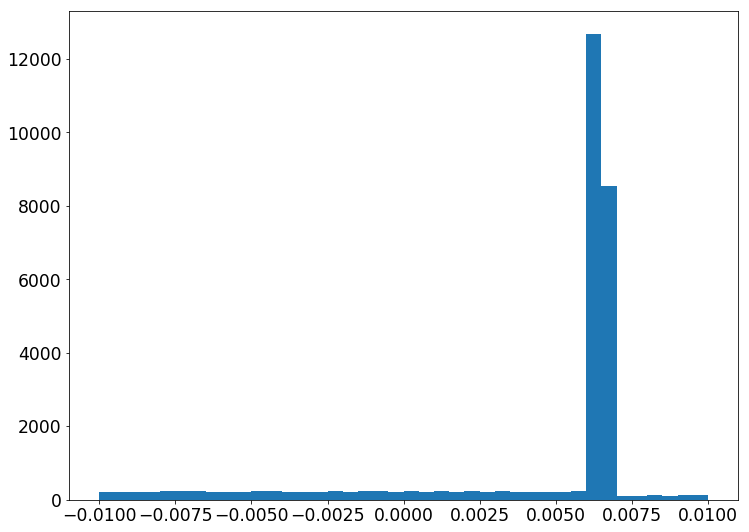

In [624]:
binsize=5e-4
limit=1e-2
plt.bar(*xcorr(stim_times, C_spikes, binsize=binsize, limit=limit), width=-binsize, align='edge')

In [625]:
sigma = 1e-3 # 0.1 ms
bins = np.arange(0, stop_time + sigma, sigma)

int(refractory/sigma), int(refractory/sigma) * refractory

(4, 0.016)

In [647]:
def calculate_response(stim_times, source, target, winsize, latency):
    src = np.searchsorted
    result = {
        'stim_response': (
            # stim response
            src(source, stim_times, 'left') <
            src(source, stim_times + winsize, 'right')),
        'syn_response': (
            # stim synaptic response
            src(target, stim_times + latency, 'left') <
            src(target, stim_times + latency + winsize, 'right'))
    }
    return result


def wald(stim_times, source, target, winsize, latency):
    """The IV estimator used in the paper"""
    responses = calculate_response(
        stim_times, source, target, winsize, latency)
    z_s1_x0 = responses['stim_response'] == 0
    z_s1_x1 = z_s1_x0 == False
    
    y_s1_x0 = responses['syn_response'][z_s1_x0]
    y_s1_x1 = responses['syn_response'][z_s1_x1]
    
    y_s1 = (y_s1_x1.mean() - y_s1_x0.mean()) / z_s1_x1.mean() #- z_s1_x0.mean())
    
    return y_s1

In [648]:
wald(stim_times, A_spikes, C_spikes, winsize, latency)

0.7349273407765916

In [649]:
wald(stim_times, B_spikes, C_spikes, winsize, latency)

0.012440536487588858

In [650]:
calculate_hit_rate(stim_times, A_spikes, winsize)

0.6896660890429219

In [635]:
calculate_hit_rate(stim_times, B_spikes, winsize)

0.6896827512663289

# PDF

In [636]:
# %load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [637]:
# %%cython
# import numpy as np
# from libc.math cimport exp, sqrt, pi

# cdef double _sqrt_2_pi = sqrt(2 * pi)


# cdef double _norm_pdf(double x):
#     return exp(- x * x / 2.0) / _sqrt_2_pi


# def cpdf(double[:] x, double[:] y, double delta_t, double sigma):
#     '''
#     Conditional probability density function (PDF) 
#     for x evaluated at y + delta_t scaled by sigma that is
#     p(Y=y|X=x) = sum_y(exp(-(z/sigma)^2) / (sqrt(2pi)*sigma)), 
#     z = x - y - delta_t.
#     '''
#     cdef int i, j, M, N
#     cdef double z, tmp
#     cdef double[:] pdf
#     M, N = len(x), len(y)
#     pdf = np.zeros(M)
#     for i in range(M):
#         for j in range(N):
#             z = x[i] - y[j] - delta_t
#             tmp = _norm_pdf(z / sigma) / sigma
#             pdf[i] = pdf[i] + tmp / N
#     return np.array(pdf)

In [638]:
# pdf_A = cpdf(stim_times, A_spikes, -stim_latency, 2e-3)
# pdf_C = cpdf(stim_times, C_spikes, -(latency + stim_latency), 2e-3)

# beta_AC = np.cov(pdf_C, pdf_A)[0,1] / np.var(pdf_C)

In [639]:
# pdf_B = cpdf(stim_times, B_spikes, -stim_latency, 2e-3)

# beta_BC = np.cov(pdf_C, pdf_B)[0,1] / np.var(pdf_C)

In [640]:
# beta_AC, beta_BC

(0.39717129436386656, 0.0062309277766178115)

# regression

In [641]:
def histogram(val, bins):
    '''
    Assuming:
        val, bins are sorted
        bins increase monotonically and uniformly
        all(bins[0] <= v <= bins[-1] for v in val)
    '''
    result = np.zeros(len(bins) - 1).astype(int)
    search = np.searchsorted(bins, val, side='right')
    cnt = np.bincount(search)[1:]
    result[:len(cnt)] = cnt[:len(result)]
    if len(cnt) > len(result):
        print('Assert', np.allclose(np.histogram(val, bins)[0], result))
    return result
    

def create_design_matrix(times, bins, n):
    result = [histogram(times, bins=bins)]
    for i in range(1, n):
        result.append(
            np.concatenate([
                np.zeros(i),
                result[0][:-i]
            ])
        )
    return np.array(result)


def OLS(X, y):
    dot, inv = np.dot, np.linalg.inv
    return dot(dot(inv(dot(X.T, X)), X.T), y)


def fit_latency(pre, post, binsize=.1, limit=[-10, 20], init=[0.5, 0.5], plot=False):
    '''
    Fit a gaussian PDF to density of CCH
    '''
    b, c = xcorr(pre, post, binsize=binsize, limit=limit, density=True)
    normpdf  = lambda p, x: st.lognorm.pdf(x, p[0], p[1])
    error  = lambda p, x, y: (y - normpdf(p, x))
    (delta_t, sigma), _ = leastsq(error, init, args=(b, c))
    if plot:
        plt.bar(b, c, width=-binsize, align='edge')
        y = normpdf((delta_t, sigma), b)
        plt.plot(b, y, 'r--', linewidth=2)
        plt.title('$\Delta t$ {:.2f} $\sigma$ {:.2f}'.format(delta_t, sigma))
#         plt.axvspan(delta_t - sigma, delta_t + sigma, alpha=.5, color='cyan')
    return delta_t, sigma


def IV(pre, post, stim_times, stop_time, stim_duration, sigma, refractory, latency, plot=False):

    bins = np.arange(0, stop_time + sigma, sigma)
    
    pre_binary_design = create_design_matrix(
        pre, bins, int(refractory / sigma) + 1)
    
    X = pre_binary_design[0]
    Z = pre_binary_design[1:]
    
    S = create_design_matrix(
        stim_times, bins, int(stim_duration / sigma) + 1).sum(axis=0).astype(bool)
    
    Y = histogram(post - latency + stim_duration / 2, bins=bins)
    
    Z = Z.T
    Z = np.hstack((np.ones((Z.shape[0], 1)), Z))
    
    W = OLS(Z, X)
    X_fittedvalues = np.dot(W, Z.T)
    
    if plot:
        xlim = [.1, .8]
        mask = (bins[1:] > xlim[0]) & (bins[1:] < xlim[1])
        plt.plot(bins[1:][mask], X_fittedvalues[mask], label='fitted values')   
        plt.bar(bins[1:][mask], S[mask]*1.5, width=-sigma, align='edge', label='S', alpha=.5, zorder=1000)
        plt.bar(bins[1:][mask], X[mask], width=-sigma, align='edge', label='X')
        plt.bar(bins[1:][mask], Y[mask], width=-sigma, align='edge', label='Y')
        plt.legend(bbox_to_anchor=(0., 1.00, 1., .102), loc=3,
                   ncol=4, mode="expand", frameon=False)
        plt.xlabel('time (s)')
        plt.xlim(xlim)
        plt.legend()
    
    Y = Y[S]
    X_fittedvalues = X_fittedvalues[S]
    
    XX = np.array([np.ones(X_fittedvalues.shape[0]), X_fittedvalues])

    _, beta_IV = OLS(XX.T, Y)
    
    return beta_IV

Text(0.5,1,'beta_IV -5.201198112893634')

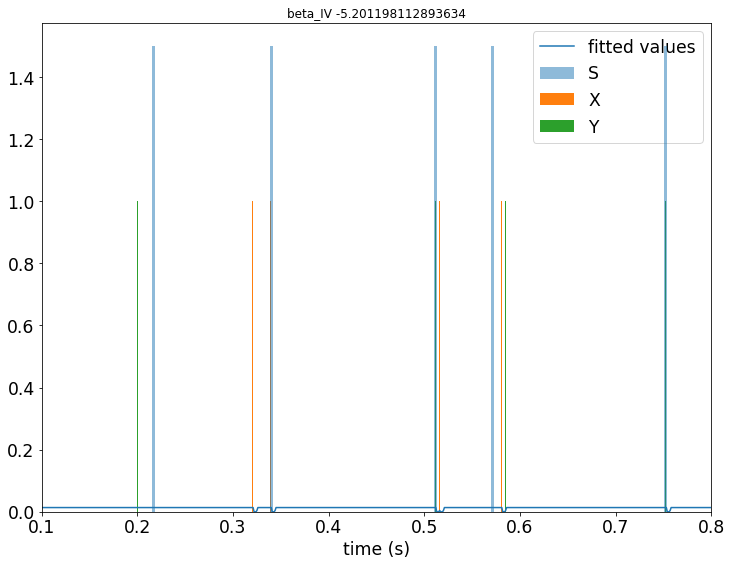

In [642]:
beta_AC = IV(
    pre=A_spikes, post=C_spikes, stim_times=stim_times, stop_time=stop_time, stim_duration=2e-3,
    sigma=1e-3, refractory=refractory, latency=latency + stim_latency, plot=True)
plt.title('beta_IV {}'.format(beta_AC))

Text(0.5,1,'beta_IV 0.06638358928052698')

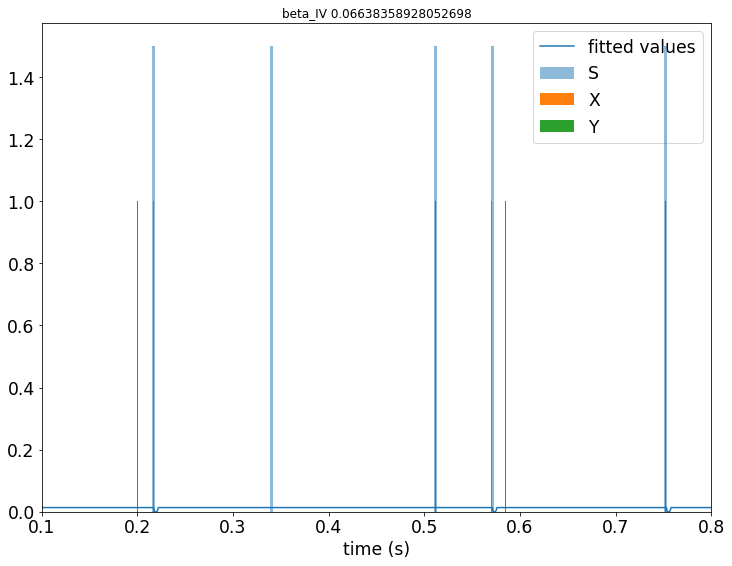

In [643]:
beta_BC = IV(
    pre=B_spikes, post=C_spikes, stim_times=stim_times, stop_time=stop_time, stim_duration=2e-3,
    sigma=1e-3, refractory=refractory, latency=latency + stim_latency, plot=True)
plt.title('beta_IV {}'.format(beta_BC))

In [644]:
beta_AC = IV(
    A_spikes, C_spikes, stim_times, stop_time, 2e-3,
    sigma=1e-3, refractory=refractory, latency=latency + stim_latency)
beta_BC = IV(
    B_spikes, C_spikes, stim_times, stop_time, 2e-3,
    sigma=1e-3, refractory=refractory, latency=latency + stim_latency)

time_shift = 15

beta_ACr = IV(
    A_spikes, C_spikes, stim_times - time_shift, stop_time, 2e-3,
    sigma=1e-3, refractory=refractory, latency=latency + stim_latency)
beta_BCr = IV(
    B_spikes, C_spikes, stim_times - time_shift, stop_time, 2e-3,
    sigma=1e-3, refractory=refractory, latency=latency + stim_latency)

beta_AC, beta_BC, beta_ACr, beta_BCr

(-5.201198112893634,
 0.06638358928052698,
 -5.259181186000254,
 -2.293371104617649)